In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [20]:
# Load dataset
file_path = '../data/car_sales.csv'
car = pd.read_csv(file_path)

In [21]:
# Step 1: Data Exploration
# Display basic information about the dataset
print(car.describe())
print(car.info())

       Annual Income     Price ($)         Phone
count   2.390600e+04  23906.000000  2.390600e+04
mean    8.308403e+05  28090.247846  7.497741e+06
std     7.200064e+05  14788.687608  8.674920e+05
min     1.008000e+04   1200.000000  6.000101e+06
25%     3.860000e+05  18001.000000  6.746495e+06
50%     7.350000e+05  23000.000000  7.496198e+06
75%     1.175750e+06  34000.000000  8.248146e+06
max     1.120000e+07  85800.000000  8.999579e+06
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         

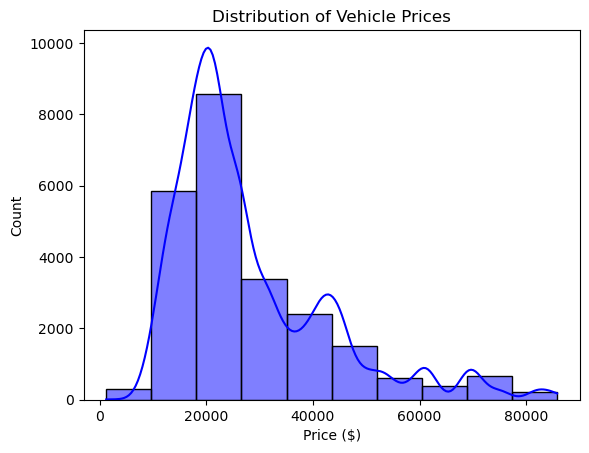

In [22]:
# Step 2: Data Visualization
# Distribution of Vehicle Prices
sns.histplot(data=car, x='Price ($)', bins=10, kde=True, color='blue')
plt.title('Distribution of Vehicle Prices')
plt.show()

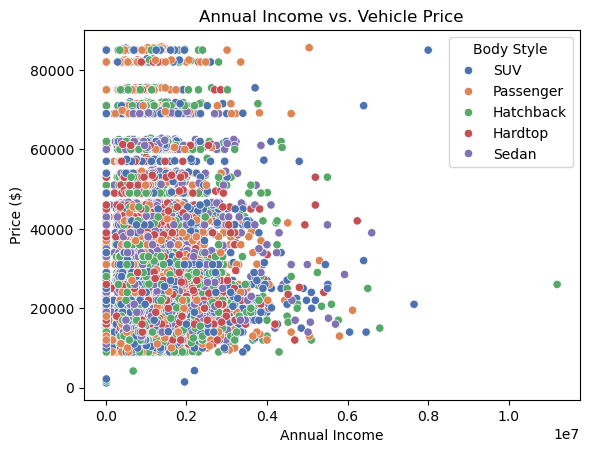

In [23]:
# Annual Income vs. Vehicle Price
sns.scatterplot(data=car, x='Annual Income', y='Price ($)', hue='Body Style', palette='deep')
plt.title('Annual Income vs. Vehicle Price')
plt.show()

/var/folders/qt/l2qz_x2s25s9bn9zhf9ynxp40000gn/T/ipykernel_999/3279013552.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=car, x='Dealer_Region', palette='pastel')


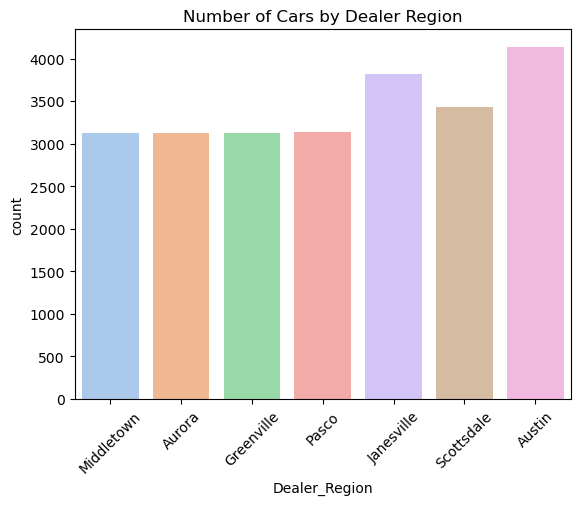

In [24]:
# Number of Cars by Dealer Region
sns.countplot(data=car, x='Dealer_Region', palette='pastel')
plt.title('Number of Cars by Dealer Region')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Visualize Clustering Results
# Convert 'Gender' and 'Dealer_Region' to numerical labels for clustering visualization
label_encoder = LabelEncoder()
car['Gender_Label'] = label_encoder.fit_transform(car['Gender'])
car['Dealer_Region_Label'] = label_encoder.fit_transform(car['Dealer_Region'])

# Clustering based on demographic features
demographic_features = car[['Gender_Label', 'Annual Income', 'Dealer_Region_Label']]
scaler = StandardScaler()
demographic_features_scaled = scaler.fit_transform(demographic_features)

kmeans = KMeans(n_clusters=3, random_state=42)
car['Cluster'] = kmeans.fit_predict(demographic_features_scaled)

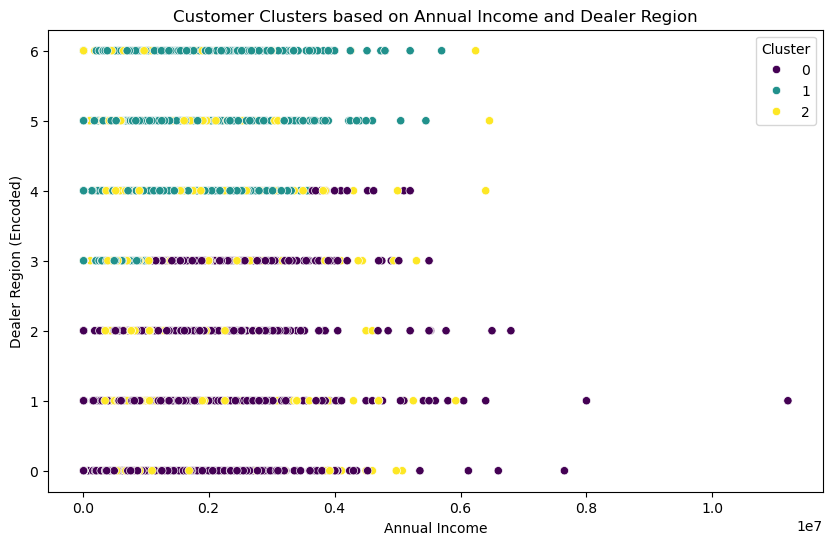

In [26]:
# Plot clusters based on Annual Income and Dealer Region
plt.figure(figsize=(10, 6))
sns.scatterplot(data=car, x='Annual Income', y='Dealer_Region_Label', hue='Cluster', palette='viridis')
plt.title('Customer Clusters based on Annual Income and Dealer Region')
plt.xlabel('Annual Income')
plt.ylabel('Dealer Region (Encoded)')
plt.show()

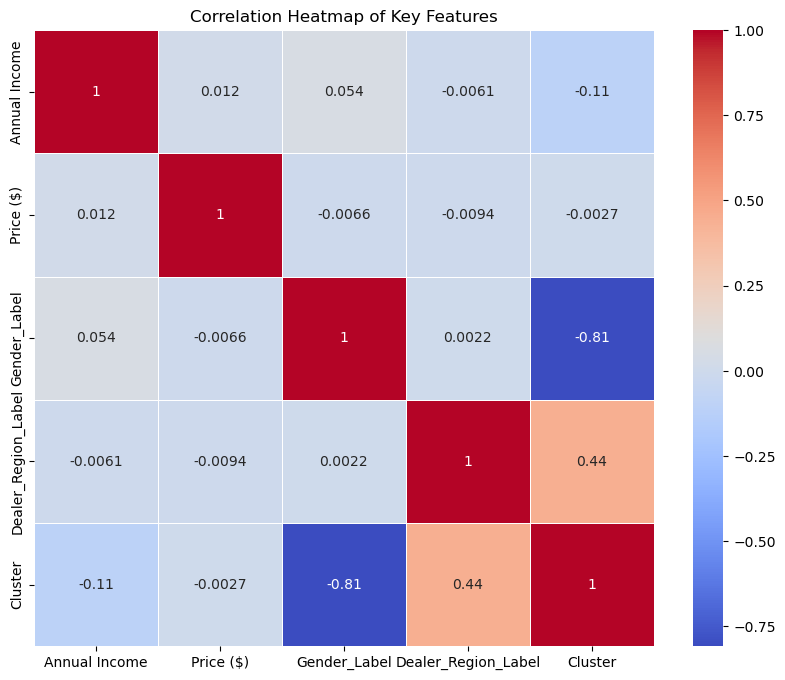

In [27]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = car[['Annual Income', 'Price ($)', 'Gender_Label', 'Dealer_Region_Label', 'Cluster']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Key Features')
plt.show()


In [29]:
# Step 3: Classification Task - Predict Car Category (Body Style)
# Define features and target variable for Body Style Prediction
X_body_style = car.drop(['Body Style', 'Date', 'Price ($)', 'Cluster'], axis=1)
y_body_style = car['Body Style']

In [30]:
# Preprocessing pipeline: One-hot encode categorical columns and scale numerical columns
preprocessor_class = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Gender', 'Company', 'Transmission', 'Color', 'Dealer_Region']),
        ('num', StandardScaler(), ['Annual Income'])
    ])

In [31]:
# Define pipeline for classification model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_class),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [32]:
# Split data into training and testing sets for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_body_style, y_body_style, test_size=0.2, random_state=42)

In [33]:
# Train and evaluate RandomForestClassifier
pipeline_rf.fit(X_train_cls, y_train_cls)
y_pred_rf = pipeline_rf.predict(X_test_cls)
print("Random Forest Classifier Accuracy:", accuracy_score(y_test_cls, y_pred_rf))
print(classification_report(y_test_cls, y_pred_rf))

Random Forest Classifier Accuracy: 0.41760769552488497
              precision    recall  f1-score   support

     Hardtop       0.23      0.22      0.22       572
   Hatchback       0.39      0.41      0.40      1200
   Passenger       0.43      0.41      0.42       804
         SUV       0.46      0.45      0.46      1304
       Sedan       0.50      0.51      0.50       902

    accuracy                           0.42      4782
   macro avg       0.40      0.40      0.40      4782
weighted avg       0.42      0.42      0.42      4782



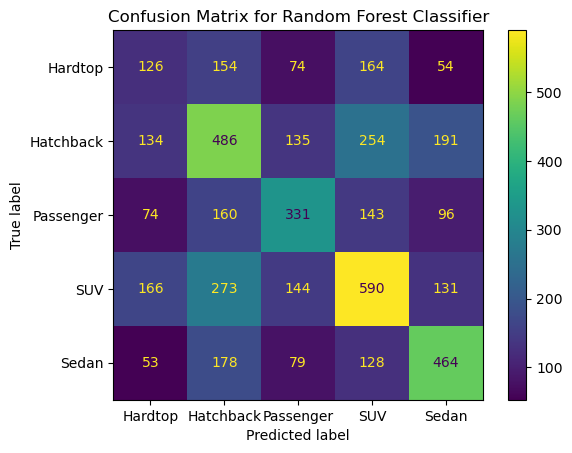

In [34]:
# Display Confusion Matrix for RandomForestClassifier
conf_matrix_rf = confusion_matrix(y_test_cls, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=pipeline_rf.named_steps['classifier'].classes_).plot()
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [38]:
# Feature importance using permutation importance for RandomForestClassifier
importance_rf = permutation_importance(pipeline_rf, X_test_cls, y_test_cls, n_repeats=10, random_state=42)
cat_features = pipeline_rf.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
num_features = ['Annual Income']
feature_names = np.concatenate([cat_features, num_features])
importances_df = pd.DataFrame({'Feature': feature_names[:len(importance_rf.importances_mean)], 'Importance': importance_rf.importances_mean}).sort_values(by='Importance', ascending=False)
print("Feature Importance for Random Forest Classifier:")
print(importances_df)

Feature Importance for Random Forest Classifier:
              Feature  Importance
5       Company_Buick    0.198285
8    Company_Chrysler    0.084170
9       Company_Dodge    0.081054
3        Company_Audi    0.005102
1         Gender_Male    0.000000
4         Company_BMW    0.000000
0       Gender_Female    0.000000
11      Company_Honda    0.000000
6    Company_Cadillac    0.000000
7   Company_Chevrolet    0.000000
10       Company_Ford    0.000000
14     Company_Jaguar    0.000000
13   Company_Infiniti    0.000000
2       Company_Acura   -0.000544
12    Company_Hyundai   -0.000836


In [39]:
# Step 4: Regression for Price Prediction
# Define features and target for regression
X_price = car[['Gender', 'Annual Income', 'Dealer_Region', 'Transmission', 'Engine']]
y_price = car['Price ($)']

In [40]:
# Preprocessing pipeline for regression
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Gender', 'Dealer_Region', 'Transmission', 'Engine']),
        ('num', StandardScaler(), ['Annual Income'])
    ])

# Define and train regression model
pipeline_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [41]:
# Split data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

In [42]:
# Train and evaluate regression model
pipeline_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = pipeline_reg.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f'RMSE for Price Prediction: {rmse:.2f}')

RMSE for Price Prediction: 16379.83


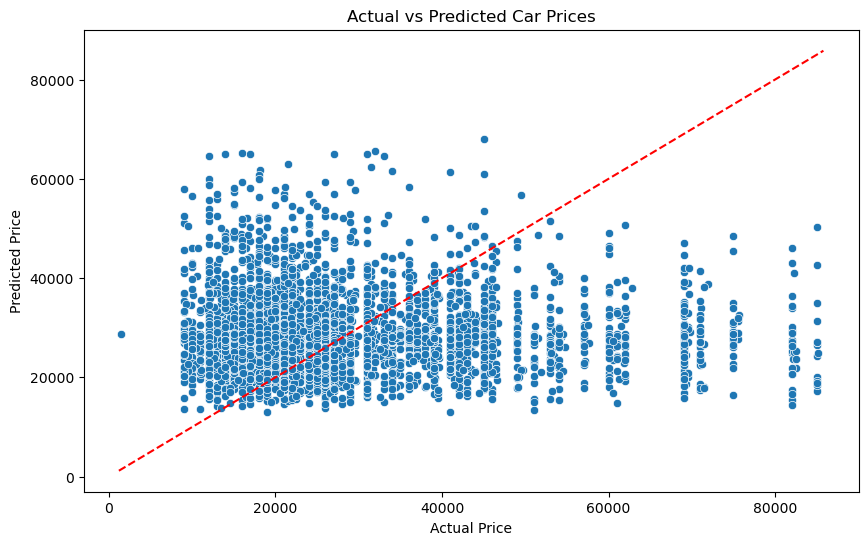

In [43]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.plot([y_price.min(), y_price.max()], [y_price.min(), y_price.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted Car Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


In [44]:
# Cross-validation for regression
cv_scores = cross_val_score(pipeline_reg, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE: {cv_rmse.mean():.2f} +/- {cv_rmse.std():.2f}')

Cross-Validation RMSE: 16402.84 +/- 133.52
